## Dependencies

In [384]:
import re
import warnings

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [302]:
pd.set_option("display.max_rows", None, "display.max_columns", None) # Let pandas print the entire dataframe
warnings.filterwarnings('ignore')
%matplotlib inline

## Record Correct and Mismatched Data Type

In [285]:
# Set path of train, test data
data_train_path = r'D:\pythonProject\hello_fresh_go_tasks\model_and_data\b2b_data_train - b2b_data_train.csv'
data_test_path = r'D:\pythonProject\hello_fresh_go_tasks\model_and_data\b2b_data_test - b2b_data_test.csv'


# Load csv files into pandas dataframes
df_train = pd.read_csv(data_train_path)
df_test = pd.read_csv(data_test_path)


# Label column is the one absent from test data set.
global label_col_name
label_col_name = set(df_train.columns.values) - set(df_test.columns.values)

In [286]:
# We need to first identfy the type of each column for further processing.
# We have to copy and paste the column name from the index object rather than directly from the display. 

df_column_type = df_train.dtypes.to_frame(name = 'data_type')
df_data_sample = df_train.head(2).T 
df_data_sample = df_data_sample.rename(columns = {
                                                  0:'data_sample_0',
                                                  1:'data_sample_1'
                                                  })
df_check_data_type = df_column_type.join(df_data_sample)
display(df_check_data_type)

,data_type,data_sample_0,data_sample_1
Fridge ID,int64,5370,5637
City,object,Berlin,Berlin
Location,object,Central,Fringe
Year Founded,int64,2011,2016
Maturity,object,immature,immature
Industry,object,Service,Service
IndustryNew,object,E-Commerce,"B2C Software, Apps and Digital Services"
Company Type,object,Grownup,Startup
Company Type*,object,Mature Start-Up,Growing Start-Up
Employee Type,object,White Collar,White Collar


In [287]:
# Now we pick up the columns which has the correct and wrong formats, then categorize them.  

clean_int_columns = [
    'Fridge ID',
    'Year Founded',
    'Office Size'  
] 

clean_str_columns = [
    'City',
    'Location',
    'Maturity',
    'Industry',
    'IndustryNew',
    'Company Type',
    'Company Type*', 
    'Employee Type',
    'Innercompany Location',
    'Lead Source',
    'Fridge Type'  
] 

clean_float_columns = [
    
    'Registered Users',
    'Active users (weekly average 2019 per terminal)',
    'Basket size/User/Week', 'Male/Female Ratio',
    '# Newsletter subscriptions',
    '# Fingerprints',
    '# Restaurants nearby',
    'Avg. NPS Score'  
]

# There is an unwanted 'Û' in these columns
global columns_remove_U_and_convert_str_to_float 
columns_remove_U_and_convert_str_to_float = [
    'Service Fee', 
    'Subsidy', 
    'Revenue'
]

# We have to convert the str type to float type
global columns_remove_percentage_and_convert_str_to_float
columns_remove_percentage_and_convert_str_to_float = [
    'NL/User', 
    'FP/User'
]


checked_columns = [
    clean_int_columns,
    clean_str_columns,
    clean_float_columns,
    columns_remove_U_and_convert_str_to_float,
    columns_remove_percentage_and_convert_str_to_float
]

# Verify whether we have checked all the columns
total_num_columns = len(df_train.columns) 
checked_columns = [x for xs in checked_columns for x in xs]
num_missed_column = total_num_columns - len(checked_columns)

try:
    0 == num_missed_column
    print(f'We have checked all {total_num_columns} columns')
    
except ValueError:
    raise ValueError(f"We have missed to check {num_missed_column} columns")

We have checked all 27 columns


## Correct Mismatched Data Type

In [288]:
# We create a function to wrap ip the cleaning and encoding process and apply them to both train and test set.
# i.e., we need to creat several udf for pandas dataframe, although udf is slow applied to big dataframe. 

def func_remove_U_and_convert_str_to_float(cell):
    try:
        cell = re.sub('[^0-9.]', "", cell.replace(",","."))
        return float(cell)
    except:
        return np.nan   # missing value is casted to -1.
 
def func_remove_percentage_and_convert_str_to_float(cell):
    try:
        cell = cell.replace("%","")
        return float(cell)
    
    except:   
        return np.nan
    

def apply_udf(df,columns,func):
    for col in columns:
        df[col] = df.apply(lambda x: func(x[col]),axis = 1)
        
    return df


def clean_data(df,data_type):
   
    df = apply_udf(
        df,
        columns_remove_percentage_and_convert_str_to_float,
        func_remove_percentage_and_convert_str_to_float
    )
    
    if data_type == 'train':
        df = apply_udf(
            df,
            columns_remove_U_and_convert_str_to_float,
            func_remove_U_and_convert_str_to_float
        )
    elif data_type == 'test':
        df = apply_udf(
            df,
            set(columns_remove_U_and_convert_str_to_float) - label_col_name,
            func_remove_U_and_convert_str_to_float
        )
    else:
        raise ValueError("data_type input is wrong")
    
    return df

## Check Missing Value and Fill String Valued Column

In [289]:
def get_missing_value_percentage(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({
        'percent_missing': percent_missing
    })
    missing_value_df.sort_values('percent_missing', inplace=True)
    
    return missing_value_df


df_train = clean_data(df_train,'train')
df_test = clean_data(df_test,'test')

global numeric_colunms
global str_columns
numeric_colunms = set(checked_columns)\
               - set(clean_str_columns)
str_columns = clean_str_columns

global str_column_fillna_value
str_column_fillna_value = 'Unknown'

In [502]:
# We fill 'unknown' in the string valued column if the value is missing.
# we fill with the average value if the value is missing in that column.
     
        
def fill_missing_value(df,numeric_features,str_features):
    
    df_str = df[str_features]
    df_numeric = df[numeric_features]
    
    df_numeric = df_numeric.fillna(value=df_numeric.mean())
    df_str = df_str.fillna(value=str_column_fillna_value)
    df = pd.concat([df_numeric, df_str],axis=1)
    return df

## Check Correlation Between All Columns

In [503]:
# We use the whole training data to get the Heatmap matrix which gives us an overview of all pair correlations.
df_train = fill_missing_value(df_train, numeric_colunms,str_columns)   
df_test = fill_missing_value(df_test, numeric_colunms-label_col_name, str_columns) 
corr = df_train.corr()
display(corr)

,# Restaurants nearby,Male/Female Ratio,# Fingerprints,Subsidy,# Newsletter subscriptions,Active users (weekly average 2019 per terminal),NL/User,Revenue,Registered Users,FP/User,Fridge ID,Basket size/User/Week,Service Fee,Year Founded,Office Size,Avg. NPS Score
# Restaurants nearby,1.000000,-0.041986,-0.020948,-0.033123,0.038703,-0.038554,-0.133312,-0.116038,0.074876,-0.166167,-0.136249,-0.199906,-0.038732,0.181424,0.038403,-0.029451
Male/Female Ratio,-0.041986,1.000000,-0.058084,0.024339,-0.108796,-0.095928,-0.134380,-0.076353,-0.090666,0.052112,0.074107,0.071858,-0.018165,-0.157158,0.130431,0.000287
# Fingerprints,-0.020948,-0.058084,1.000000,-0.004526,0.838215,0.619787,-0.073070,0.504865,0.808139,0.300165,-0.383138,-0.262434,0.083479,0.119853,0.248893,0.139418
Subsidy,-0.033123,0.024339,-0.004526,1.000000,-0.067446,0.168224,0.045030,0.273119,-0.073152,0.123439,-0.062084,0.195651,0.088171,0.049700,-0.160370,0.053320
# Newsletter subscriptions,0.038703,-0.108796,0.838215,-0.067446,1.000000,0.513393,0.127295,0.377834,0.931704,0.041817,-0.325508,-0.274559,0.078897,0.047212,0.369071,0.147824
Active users (weekly average 2019 per terminal),-0.038554,-0.095928,0.619787,0.168224,0.513393,1.000000,0.006375,0.942982,0.426166,0.201689,-0.349677,-0.122782,0.042203,0.159023,0.069749,0.104361
NL/User,-0.133312,-0.134380,-0.073070,0.045030,0.127295,0.006375,1.000000,0.001673,-0.100766,0.261969,0.094979,0.121355,0.103900,-0.202475,-0.036241,0.225991
Revenue,-0.116038,-0.076353,0.504865,0.273119,0.377834,0.942982,0.001673,1.000000,0.309066,0.228317,-0.305169,0.132400,0.025224,0.143770,0.004965,0.108391
Registered Users,0.074876,-0.090666,0.808139,-0.073152,0.931704,0.426166,-0.100766,0.309066,1.000000,-0.008235,-0.330997,-0.271734,0.060204,0.117776,0.324528,0.077985
FP/User,-0.166167,0.052112,0.300165,0.123439,0.041817,0.201689,0.261969,0.228317,-0.008235,1.000000,-0.187896,0.070158,-0.003535,-0.051898,-0.126899,0.069560


In [504]:
# For now, we care about the correlation between the features and the to be predicted value.
# The correlation between 'Active users (weekly average 2019 per terminal)' and 'Revenue' is around 94%. 
display(df_train[df_train.columns[1:]].corr()[label_col_name][:-1].sort_values(by='Revenue',ascending=False))

,Revenue
Revenue,1.000000
Active users (weekly average 2019 per terminal),0.942982
# Fingerprints,0.504865
# Newsletter subscriptions,0.377834
Registered Users,0.309066
Subsidy,0.273119
FP/User,0.228317
Year Founded,0.143770
Basket size/User/Week,0.132400
Service Fee,0.025224


<AxesSubplot:xlabel='{Revenue}', ylabel='Active users (weekly average 2019 per terminal)'>

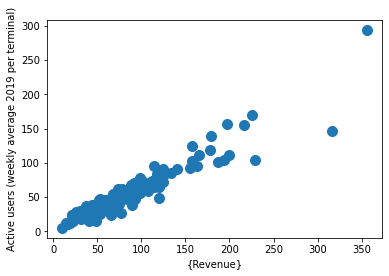

In [505]:
# Visually, we see that their relation is highly linear.
# i.e. the more the 'Active users (weekly average 2019 per terminal)' the more 'Revenue' will become.
df_train.plot.scatter(x = label_col_name, y = 'Active users (weekly average 2019 per terminal)', s = 100)

## Baseline Model: Linear Regression

In [557]:
# We see that the relation between these two columns is highly linear (correlation is ca.94%) 
# this suggests us to build a model using 'Active users (weekly average 2019 per terminal)' to predict 'Revenue'.
# In order to avoid data leakage, we will split the data into train, validation, test and process the data again.

data = pd.read_csv(data_train_path)
data = clean_data(data,'train')
(size_test_set,_) = pd.read_csv(data_test_path).shape
(size_train_set,_) = data.shape

In [558]:
# We choose str columns with number of unique value <=7, otherwise the resulted table is too sparse
display(data[str_columns].nunique().sort_values())
global str_columns_get_dummies
str_columns_get_dummies = [
    'Location',
    'Maturity',
    'Fridge Type',
    'City',    # we ignore the wired signs in the city names, since they do not bother us.
    'Employee Type' 
]
data_dummies = pd.get_dummies(data[str_columns_get_dummies])
dummies_columns = set(data_dummies.columns)
data = pd.concat([data, data_dummies],axis=1)

Location                  2
Maturity                  2
Fridge Type               2
Company Type*             4
City                      7
Employee Type             7
Lead Source              13
IndustryNew              15
Company Type             19
Industry                 27
Innercompany Location    28
dtype: int64

In [559]:
def get_loss(model,numeric_features,str_features,data,train_index,test_index):
    
    features = numeric_features|str_features
    train_data = data.iloc[train_index]
    test_data  = data.iloc[test_index]
    train_data = fill_missing_value(train_data,numeric_features,str_features)
    test_data = fill_missing_value(test_data,numeric_features,str_features)

    X_train = train_data[features-label_col_name]
    y_train = train_data[label_col_name]
    X_test = test_data[features-label_col_name]
    y_test = test_data[label_col_name]

    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    msr = mean_squared_error(y_test, y_pred)
    
    return msr


random_state = 12883823
# we set the n_splits as following to make sure that the size of the hold out set is euqal to the size of test data 
rkf = RepeatedKFold(n_splits=int(size_train_set/size_test_set), n_repeats=10, random_state=random_state)
n = 1
lr_baseline_loss = 0
lr_positive_corr_loss = 0
lr_all_features_loss = 0
xgb_reg_loss = 0

for train_index, test_index in rkf.split(data):
    
    lr = lr
    xgb_reg = XGBRegressor()
    
    lr_baseline_features = set(['Active users (weekly average 2019 per terminal)']) \
                         | label_col_name
    
    lr_positive_corr_features = set([
                                    'Active users (weekly average 2019 per terminal)',
                                    '# Fingerprints',
                                    '# Newsletter subscriptions',
                                    'Registered Users',
                                    'Subsidy',
                                    'FP/User',
                                    'Year Founded',
                                    'Basket size/User/Week'
                                 ])\
                               | label_col_name
                               
    
    
   
    lr_baseline_loss += get_loss(
        model=lr,
        numeric_features=lr_baseline_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    
    lr_positive_corr_loss += get_loss(
        model=lr,
        numeric_features=lr_positive_corr_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    lr_all_features_loss += get_loss(
        model=lr,
        numeric_features=numeric_colunms,
        str_features = dummies_columns,
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    
    xgb_reg_loss += get_loss(
        model=xgb_reg,
        numeric_features=numeric_colunms,
        str_features = set([]),#dummies_columns,
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    
    n +=1

    
print('-lr base line: ',round(lr_baseline_loss/n), 
      '-lr more features:',round(lr_positive_corr_loss/n),
      '-lr all features: ', round(lr_all_features_loss/n),
      '-lr xgb reg: ', round(xgb_reg_loss/n)
      )

-lr base line:  360 -lr more features: 181 -lr all features:  208 -lr xgb reg:  466


In [ ]:
# Because linear regression is sensitive to outliers, after remove them we have a better result.
# remove revenue > 300 data points
data = pd.read_csv(data_train_path)
data = clean_data(data,'train')
(size_test_set,_) = pd.read_csv(data_test_path).shape
(size_train_set,_) = data.shape
data = data[data.Revenue<300] #300
#data = data[data['Active users (weekly average 2019 per terminal)']<200]

display(data[str_columns].nunique().sort_values())
global str_columns_get_dummies
str_columns_get_dummies = [
    'Location',
    'Maturity',
    'Fridge Type',
    'City',    # we ignore the wired signs in the city names, since they do not bother us.
    'Employee Type' 
]
data_dummies = pd.get_dummies(data[str_columns_get_dummies])
dummies_columns = set(data_dummies.columns)
data = pd.concat([data, data_dummies],axis=1)

def get_loss(model,numeric_features,str_features,data,train_index,test_index):
    
    features = numeric_features|str_features
    train_data = data.iloc[train_index]
    test_data  = data.iloc[test_index]
    train_data = fill_missing_value(train_data,numeric_features,str_features)
    #train_data = train_data[train_data.Revenue < 300]
    test_data = fill_missing_value(test_data,numeric_features,str_features)
    
    
    X_train = train_data[features-label_col_name]
    y_train = train_data[label_col_name]
    X_test = test_data[features-label_col_name]
    y_test = test_data[label_col_name]

    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    msr = mean_squared_error(y_test, y_pred)
    
    return msr


random_state = 12883823
# we set the n_splits as following to make sure that the size of the hold out set is euqal to the size of test data 
rkf = RepeatedKFold(n_splits=int(size_train_set/size_test_set), n_repeats=10, random_state=random_state)
n = 1
lr_baseline_loss = 0
lr_positive_corr_loss = 0
lr_all_features_loss = 0
xgb_reg_loss = 0

for train_index, test_index in rkf.split(data):
    
    lr = lr
    xgb_reg = XGBRegressor()
    
    lr_baseline_features = set(['Active users (weekly average 2019 per terminal)']) \
                         | label_col_name
    
    lr_positive_corr_features = set([
                                    'Active users (weekly average 2019 per terminal)',
                                    '# Fingerprints',
                                    '# Newsletter subscriptions',
                                    'Registered Users',
                                    'Subsidy',
                                    'FP/User',
                                    'Year Founded',
                                    'Basket size/User/Week'
                                 ])\
                               | label_col_name
                               
    
    
   
    lr_baseline_loss += get_loss(
        model=lr,
        numeric_features=lr_baseline_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    
    lr_positive_corr_loss += get_loss(
        model=lr,
        numeric_features=lr_positive_corr_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    lr_all_features_loss += get_loss(
        model=lr,
        numeric_features=numeric_colunms,
        str_features = dummies_columns,
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    
    xgb_reg_loss += get_loss(
        model=xgb_reg,
        numeric_features=numeric_colunms,
        str_features = set([]),#dummies_columns,
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    
    n +=1

    
print('-lr base line: ',round(lr_baseline_loss/n), 
      '-lr more features:',round(lr_positive_corr_loss/n),
      '-lr all features: ', round(lr_all_features_loss/n),
      '-lr xgb reg: ', round(xgb_reg_loss/n)
      )

Location                  2
Maturity                  2
Fridge Type               2
Company Type*             4
City                      7
Employee Type             7
Lead Source              13
IndustryNew              15
Company Type             19
Industry                 27
Innercompany Location    28
dtype: int64

In [568]:
data = pd.read_csv(data_train_path)
data = clean_data(data,'train')
(size_test_set,_) = pd.read_csv(data_test_path).shape
(size_train_set,_) = data.shape

In [569]:
data_compare = data[['Office Size','Active users (weekly average 2019 per terminal)','Fridge ID']]
data_compare['ratio'] =data_compare['Active users (weekly average 2019 per terminal)'] /data_compare['Office Size']

<AxesSubplot:ylabel='Frequency'>

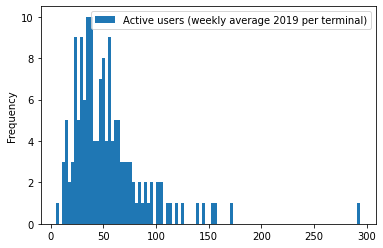

In [570]:
data[['Active users (weekly average 2019 per terminal)']].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

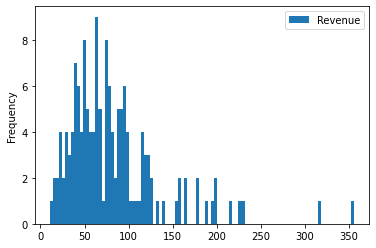

In [571]:
data[['Revenue']].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

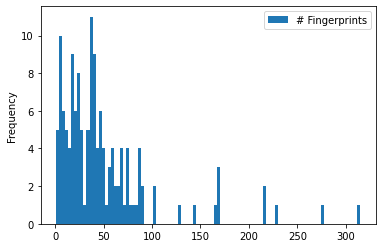

In [573]:
data[['# Fingerprints']].plot.hist(bins=100)